In [309]:
import torch
import torch.nn as nn
from setuptools.command.rotate import rotate
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torchmetrics import Accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from tqdm import tqdm
import torch.optim as optim



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhishekwaghchaure/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhishekwaghchaure/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhishekwaghchaure/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Approach Without making Custom Dataset 

In [310]:
historic_data = pd.read_csv('/Users/abhishekwaghchaure/Desktop/My_practice_noteooks/Torch/NLP/Sentiment Analysis/a1_RestaurantReviews_HistoricDump.tsv', sep='\t')

fresh_data = pd.read_csv('/Users/abhishekwaghchaure/Desktop/My_practice_noteooks/Torch/NLP/Sentiment Analysis/a2_RestaurantReviews_FreshDump.tsv', sep='\t')

In [311]:
historic_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [312]:
fresh_data.head()

,Review
0,Spend your money elsewhere.
1,Their regular toasted bread was equally satisf...
2,The Buffet at Bellagio was far from what I ant...
3,"And the drinks are WEAK, people!"
4,-My order was not correct.


In [313]:
print(f"Historic data shape : {historic_data.shape}")
print(f"Fresh Data shape : {fresh_data.shape}")

Historic data shape : (900, 2)
Fresh Data shape : (100, 1)


In [314]:
print(historic_data['Liked'].value_counts())
print(historic_data['Liked'].unique())

Liked
1    496
0    404
Name: count, dtype: int64
[1 0]


In [315]:
label_map = {0:' Negative',
             1: 'Positive'}
liked_distribution = historic_data['Liked'].value_counts()


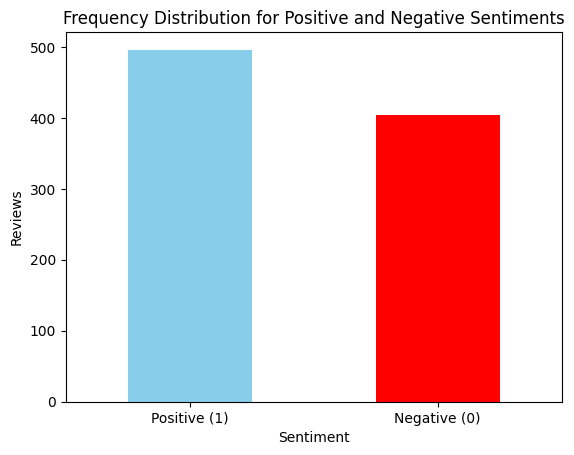

In [316]:
liked_distribution.plot(kind = 'bar', color = ['skyblue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Reviews')
plt.title('Frequency Distribution for Positive and Negative Sentiments')
plt.xticks(ticks=[0, 1], labels=['Positive (1)', 'Negative (0)'], rotation=0)
plt.show()

In [317]:
historic_review_data = historic_data['Review']
print(historic_review_data)

0                               Wow... Loved this place.
1                                     Crust is not good.
2              Not tasty and the texture was just nasty.
3      Stopped by during the late May bank holiday of...
4      The selection on the menu was great and so wer...
                             ...                        
895    I want to first say our server was great and w...
896                       The pizza selections are good.
897                I had strawberry tea, which was good.
898    Highly unprofessional and rude to a loyal patron!
899                         Overall, a great experience.
Name: Review, Length: 900, dtype: object


## Custom Dataset


In [318]:
class CustomSentimentData(Dataset):
    def __init__(self,csv_file):
        self.csv_file = csv_file
        

## Preprocessing The Text Function 

In [319]:
# Assuming `historic_review_data` is a pandas Series containing individual reviews
def text_preprocessing(data):
    lemmatizer = WordNetLemmatizer()
    corpus = []
       
    for sentence in data:
        cleaned_sentence = re.sub("[^a-zA-Z]", " ", sentence)
        cleaned_sentence = cleaned_sentence.lower()
            
        words = nltk.word_tokenize(cleaned_sentence)
            
        stemmed_words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words("english"))]
            
        final_sentence = " ".join(stemmed_words)
        corpus.append(final_sentence)
    
    return corpus

# Call the function and print the results
processed_data = text_preprocessing(historic_review_data)
print(processed_data)

['wow loved place', 'crust good', 'tasty texture nasty', 'stopped late may bank holiday rick steve recommendation loved', 'selection menu great price', 'getting angry want damn pho', 'honeslty taste fresh', 'potato like rubber could tell made ahead time kept warmer', 'fry great', 'great touch', 'service prompt', 'would go back', 'cashier care ever say still ended wayyy overpriced', 'tried cape cod ravoli chicken cranberry mmmm', 'disgusted pretty sure human hair', 'shocked sign indicate cash', 'highly recommended', 'waitress little slow service', 'place worth time let alone vega', 'like', 'burrittos blah', 'food amazing', 'service also cute', 'could care less interior beautiful', 'performed', 'right red velvet cake ohhh stuff good', 'never brought salad asked', 'hole wall great mexican street taco friendly staff', 'took hour get food table restaurant food luke warm sever running around like totally overwhelmed', 'worst salmon sashimi', 'also combo like burger fry beer decent deal', 'li

## Creating Vocabulary and Indexing 

In [320]:
def word_to_idx_vocab(preprocessed_data):
    all_words = [word for sentence in preprocessed_data for word in nltk.word_tokenize(sentence)]
    word_to_idx = {word : idx+1 for idx,word in enumerate(set(all_words))}
    # pad_idx = 0
    word_to_idx['<PAD>'] = 0
    
    indexed_historic_data = [[word_to_idx[word] for word in nltk.word_tokenize(sent)] for sent in processed_data]
    indexed_historic_padded = pad_sequence(
        [torch.tensor(sent) for sent in indexed_historic_data],
        padding_value = 0,
        batch_first=True
    )
    # 
    # return {
    #     'all_words': all_words,
    #     'word_to_idx': word_to_idx,
    #     'indexed_historic_padded' : indexed_historic_padded,
    #     'indexed_historic_data' : indexed_historic_data
    # }
    return all_words, word_to_idx, indexed_historic_padded, indexed_historic_data

In [321]:
all_words, word_to_idx, indexed_historic_padded, indexed_historic_data = word_to_idx_vocab(processed_data)

In [322]:
print(len(all_words))
print(indexed_historic_padded.shape)
print((len(indexed_historic_data[0])))
print(len(indexed_historic_padded[0]))

4919
torch.Size([900, 19])
3
19


## Embedding

Just checking how embedding will work with num_dimension = 10, num_embeddings = len(vocab)
It will be automatically taken care of in the model

In [323]:
# Hyperparameters
vocab_size = len(all_words)  # total number of words in the vocabulary, including padding
embedding_dim = 10             # you can experiment with this dimension
hidden_dim = 32                # RNN hidden layer dimension
output_dim = 1                 # output 1 value for binary classification
pad_idx = word_to_idx['<PAD>']

## Just Checking the functioning Embeddings layer 

In [324]:
num_dim = 10
# embedding = nn.Embedding(num_embeddings= len(result['all_words']), embedding_dim = num_dim)

embedding = nn.Embedding(num_embeddings= len(all_words), embedding_dim = embedding_dim, padding_idx=pad_idx)

In [325]:
final_embedded_historic = []

for sent in indexed_historic_padded:
    out_put = embedding(sent)
    # print(out_put)
    final_embedded_historic.append(out_put)
print(final_embedded_historic[0])
print(len(final_embedded_historic))
print(len(final_embedded_historic[0]))

tensor([[-2.7318,  0.8578,  0.5760,  0.0270, -0.3052, -0.6050, -0.2740,  0.7015,
          1.4476, -0.3656],
        [ 1.1504,  0.4118,  0.6142,  0.1792,  0.7512, -0.3666,  0.0883,  0.5055,
          0.2443, -1.0951],
        [ 0.0046, -0.9760, -1.7364, -0.1076, -0.3215, -0.5825, -0.2422, -0.2101,
          0.9112, -0.6358],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

## Creation of DataLoader

In [326]:
# Hyperparameters
vocab_size = len(all_words)  # total number of words in the vocabulary, including padding
batch_size = 50
embedding_dim = 100            # you can experiment with this dimension
hidden_dim = 32                # RNN hidden layer dimension
output_dim = 1                 # output 1 value for binary classification
pad_idx = word_to_idx['<PAD>']
epochs = 100
lr = 0.001
num_layers = 5

### Train and Validation

In [327]:
tensor_traindata = TensorDataset(indexed_historic_padded, torch.tensor(historic_data['Liked'],dtype = torch.int64))
train_set, val_set = torch.utils.data.random_split(tensor_traindata,[700,200])

In [328]:
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle =True)
val_dataloader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [329]:
len(train_set)

700

## Model 

In [330]:
class SimpleRNN(nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, num_layers):
        super(SimpleRNN,self).__init__()
        self.embedding_dim = embedding_dim ## Embedding_dimension -- embedding vector size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=pad_idx),
            nn.RNN(self.embedding_dim,self.hidden_size,self.num_layers, batch_first=True)
        )
        
        self.fc = (nn.Sequential(
            nn.Linear(hidden_size, output_dim),
            nn.Sigmoid()
        ))
        
    def forward(self,x):
        x = x.to(torch.long) 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, hidden = self.rnn(x)
        # final_output = hidden.squeeze(0)
        final_output = output[:,-1,:]
        x = self.fc(final_output)
        return x

In [331]:
x = torch.randint(0, vocab_size, (10, 20)) 

## Model Training

In [332]:
device = torch.device('mps')
model = SimpleRNN(vocab_size=vocab_size, embedding_dim=10, hidden_size=32, num_layers=num_layers).to(device = device)
acc = Accuracy(task='binary',num_labels = output_dim).to(device = device)
optimizer = optim.Adam(model.parameters() , lr = lr)
criterion = nn.BCELoss()

In [333]:
model.train()
for epoch in range(epochs):
    acc.reset()  # Reset accuracy counter at the start of each epoch
    epoch_train_loss = 0.0
    bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}")

    for idx, (text, labels) in bar:
        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        prediction = model(text).squeeze(1)

        loss = criterion(prediction, labels.float())
        loss.backward()
        
        optimizer.step()

        epoch_train_loss += loss.item()  # Accumulate loss
        acc.update(prediction.round(), labels)

        bar.set_postfix(loss=loss.item(), accuracy=acc.compute().item())

    avg_loss = epoch_train_loss / len(train_dataloader)  # Average loss over all batches
    avg_acc = acc.compute().item()  # Average accuracy over all samples

    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')

Epoch 1/100: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s, accuracy=0.541, loss=0.672]


Epoch 1/100, Loss: 0.6889, Accuracy: 0.5414


Epoch 2/100: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s, accuracy=0.553, loss=0.705]


Epoch 2/100, Loss: 0.6877, Accuracy: 0.5529


Epoch 3/100: 100%|██████████| 14/14 [00:01<00:00, 13.77it/s, accuracy=0.553, loss=0.682]


Epoch 3/100, Loss: 0.6880, Accuracy: 0.5529


Epoch 4/100: 100%|██████████| 14/14 [00:01<00:00, 13.88it/s, accuracy=0.554, loss=0.705]


Epoch 4/100, Loss: 0.6873, Accuracy: 0.5543


Epoch 5/100: 100%|██████████| 14/14 [00:01<00:00, 13.86it/s, accuracy=0.556, loss=0.676]


Epoch 5/100, Loss: 0.6856, Accuracy: 0.5557


Epoch 6/100: 100%|██████████| 14/14 [00:01<00:00, 13.93it/s, accuracy=0.566, loss=0.679]


Epoch 6/100, Loss: 0.6807, Accuracy: 0.5657


Epoch 7/100: 100%|██████████| 14/14 [00:01<00:00, 13.12it/s, accuracy=0.583, loss=0.672]


Epoch 7/100, Loss: 0.6811, Accuracy: 0.5829


Epoch 8/100: 100%|██████████| 14/14 [00:01<00:00, 13.86it/s, accuracy=0.574, loss=0.636]


Epoch 8/100, Loss: 0.6778, Accuracy: 0.5743


Epoch 9/100: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, accuracy=0.581, loss=0.585]


Epoch 9/100, Loss: 0.6608, Accuracy: 0.5814


Epoch 10/100: 100%|██████████| 14/14 [00:01<00:00, 13.80it/s, accuracy=0.567, loss=0.63] 


Epoch 10/100, Loss: 0.6689, Accuracy: 0.5671


Epoch 11/100: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, accuracy=0.613, loss=0.689]


Epoch 11/100, Loss: 0.6529, Accuracy: 0.6129


Epoch 12/100: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s, accuracy=0.613, loss=0.592]


Epoch 12/100, Loss: 0.6427, Accuracy: 0.6129


Epoch 13/100: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, accuracy=0.661, loss=0.657]


Epoch 13/100, Loss: 0.6313, Accuracy: 0.6614


Epoch 14/100: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, accuracy=0.64, loss=0.562] 


Epoch 14/100, Loss: 0.6293, Accuracy: 0.6400


Epoch 15/100: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, accuracy=0.669, loss=0.61] 


Epoch 15/100, Loss: 0.6103, Accuracy: 0.6686


Epoch 16/100: 100%|██████████| 14/14 [00:01<00:00, 13.85it/s, accuracy=0.694, loss=0.544]


Epoch 16/100, Loss: 0.5908, Accuracy: 0.6943


Epoch 17/100: 100%|██████████| 14/14 [00:01<00:00, 13.79it/s, accuracy=0.693, loss=0.608]


Epoch 17/100, Loss: 0.5946, Accuracy: 0.6929


Epoch 18/100: 100%|██████████| 14/14 [00:01<00:00, 13.86it/s, accuracy=0.686, loss=0.548]


Epoch 18/100, Loss: 0.5874, Accuracy: 0.6857


Epoch 19/100: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s, accuracy=0.727, loss=0.586]


Epoch 19/100, Loss: 0.5517, Accuracy: 0.7271


Epoch 20/100: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, accuracy=0.753, loss=0.444]


Epoch 20/100, Loss: 0.5178, Accuracy: 0.7529


Epoch 21/100: 100%|██████████| 14/14 [00:01<00:00, 11.48it/s, accuracy=0.773, loss=0.561]


Epoch 21/100, Loss: 0.5127, Accuracy: 0.7729


Epoch 22/100: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s, accuracy=0.781, loss=0.401]


Epoch 22/100, Loss: 0.4951, Accuracy: 0.7814


Epoch 23/100: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, accuracy=0.79, loss=0.411] 


Epoch 23/100, Loss: 0.4645, Accuracy: 0.7900


Epoch 24/100: 100%|██████████| 14/14 [00:01<00:00, 12.57it/s, accuracy=0.807, loss=0.419]


Epoch 24/100, Loss: 0.4539, Accuracy: 0.8071


Epoch 25/100: 100%|██████████| 14/14 [00:01<00:00, 11.48it/s, accuracy=0.786, loss=0.315]


Epoch 25/100, Loss: 0.4691, Accuracy: 0.7857


Epoch 26/100: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s, accuracy=0.821, loss=0.371]


Epoch 26/100, Loss: 0.4324, Accuracy: 0.8214


Epoch 27/100: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s, accuracy=0.829, loss=0.523]


Epoch 27/100, Loss: 0.4159, Accuracy: 0.8286


Epoch 28/100: 100%|██████████| 14/14 [00:01<00:00, 11.37it/s, accuracy=0.836, loss=0.527]


Epoch 28/100, Loss: 0.4011, Accuracy: 0.8357


Epoch 29/100: 100%|██████████| 14/14 [00:01<00:00, 12.37it/s, accuracy=0.847, loss=0.331]


Epoch 29/100, Loss: 0.3913, Accuracy: 0.8471


Epoch 30/100: 100%|██████████| 14/14 [00:01<00:00, 12.39it/s, accuracy=0.864, loss=0.587]


Epoch 30/100, Loss: 0.3598, Accuracy: 0.8643


Epoch 31/100: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s, accuracy=0.873, loss=0.339]


Epoch 31/100, Loss: 0.3348, Accuracy: 0.8729


Epoch 32/100: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s, accuracy=0.886, loss=0.37] 


Epoch 32/100, Loss: 0.3078, Accuracy: 0.8857


Epoch 33/100: 100%|██████████| 14/14 [00:01<00:00, 12.07it/s, accuracy=0.896, loss=0.208]


Epoch 33/100, Loss: 0.2999, Accuracy: 0.8957


Epoch 34/100: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s, accuracy=0.89, loss=0.206] 


Epoch 34/100, Loss: 0.2943, Accuracy: 0.8900


Epoch 35/100: 100%|██████████| 14/14 [00:01<00:00, 12.72it/s, accuracy=0.897, loss=0.283]


Epoch 35/100, Loss: 0.2804, Accuracy: 0.8971


Epoch 36/100: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s, accuracy=0.914, loss=0.22] 


Epoch 36/100, Loss: 0.2495, Accuracy: 0.9143


Epoch 37/100: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s, accuracy=0.919, loss=0.311]


Epoch 37/100, Loss: 0.2312, Accuracy: 0.9186


Epoch 38/100: 100%|██████████| 14/14 [00:01<00:00, 11.32it/s, accuracy=0.916, loss=0.44] 


Epoch 38/100, Loss: 0.2467, Accuracy: 0.9157


Epoch 39/100: 100%|██████████| 14/14 [00:01<00:00, 12.75it/s, accuracy=0.92, loss=0.201] 


Epoch 39/100, Loss: 0.2238, Accuracy: 0.9200


Epoch 40/100: 100%|██████████| 14/14 [00:01<00:00, 13.27it/s, accuracy=0.92, loss=0.203] 


Epoch 40/100, Loss: 0.2527, Accuracy: 0.9200


Epoch 41/100: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, accuracy=0.919, loss=0.271]


Epoch 41/100, Loss: 0.2221, Accuracy: 0.9186


Epoch 42/100: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, accuracy=0.933, loss=0.226] 


Epoch 42/100, Loss: 0.1952, Accuracy: 0.9329


Epoch 43/100: 100%|██████████| 14/14 [00:01<00:00, 13.46it/s, accuracy=0.949, loss=0.226]


Epoch 43/100, Loss: 0.1747, Accuracy: 0.9486


Epoch 44/100: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, accuracy=0.946, loss=0.203]


Epoch 44/100, Loss: 0.1616, Accuracy: 0.9457


Epoch 45/100: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, accuracy=0.94, loss=0.132] 


Epoch 45/100, Loss: 0.1671, Accuracy: 0.9400


Epoch 46/100: 100%|██████████| 14/14 [00:01<00:00, 13.54it/s, accuracy=0.931, loss=0.139] 


Epoch 46/100, Loss: 0.1748, Accuracy: 0.9314


Epoch 47/100: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, accuracy=0.946, loss=0.158]


Epoch 47/100, Loss: 0.1529, Accuracy: 0.9457


Epoch 48/100: 100%|██████████| 14/14 [00:01<00:00, 13.55it/s, accuracy=0.956, loss=0.0846]


Epoch 48/100, Loss: 0.1398, Accuracy: 0.9557


Epoch 49/100: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s, accuracy=0.959, loss=0.0404]


Epoch 49/100, Loss: 0.1381, Accuracy: 0.9586


Epoch 50/100: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, accuracy=0.954, loss=0.0877]


Epoch 50/100, Loss: 0.1390, Accuracy: 0.9543


Epoch 51/100: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s, accuracy=0.973, loss=0.142] 


Epoch 51/100, Loss: 0.1059, Accuracy: 0.9729


Epoch 52/100: 100%|██████████| 14/14 [00:01<00:00, 13.46it/s, accuracy=0.964, loss=0.073] 


Epoch 52/100, Loss: 0.1062, Accuracy: 0.9643


Epoch 53/100: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, accuracy=0.973, loss=0.0662]


Epoch 53/100, Loss: 0.0966, Accuracy: 0.9729


Epoch 54/100: 100%|██████████| 14/14 [00:01<00:00, 13.15it/s, accuracy=0.974, loss=0.0624]


Epoch 54/100, Loss: 0.0956, Accuracy: 0.9743


Epoch 55/100: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, accuracy=0.974, loss=0.0659]


Epoch 55/100, Loss: 0.0878, Accuracy: 0.9743


Epoch 56/100: 100%|██████████| 14/14 [00:01<00:00, 13.37it/s, accuracy=0.979, loss=0.0914]


Epoch 56/100, Loss: 0.0838, Accuracy: 0.9786


Epoch 57/100: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, accuracy=0.986, loss=0.0275]


Epoch 57/100, Loss: 0.0705, Accuracy: 0.9857


Epoch 58/100: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s, accuracy=0.984, loss=0.111] 


Epoch 58/100, Loss: 0.0659, Accuracy: 0.9843


Epoch 59/100: 100%|██████████| 14/14 [00:01<00:00, 13.37it/s, accuracy=0.989, loss=0.0172]


Epoch 59/100, Loss: 0.0570, Accuracy: 0.9886


Epoch 60/100: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s, accuracy=0.989, loss=0.041] 


Epoch 60/100, Loss: 0.0537, Accuracy: 0.9886


Epoch 61/100: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, accuracy=0.991, loss=0.0188]


Epoch 61/100, Loss: 0.0489, Accuracy: 0.9914


Epoch 62/100: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s, accuracy=0.989, loss=0.0391]


Epoch 62/100, Loss: 0.0519, Accuracy: 0.9886


Epoch 63/100: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, accuracy=0.976, loss=0.0186]


Epoch 63/100, Loss: 0.0780, Accuracy: 0.9757


Epoch 64/100: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, accuracy=0.964, loss=0.121] 


Epoch 64/100, Loss: 0.1114, Accuracy: 0.9643


Epoch 65/100: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s, accuracy=0.931, loss=0.295]


Epoch 65/100, Loss: 0.1914, Accuracy: 0.9314


Epoch 66/100: 100%|██████████| 14/14 [00:01<00:00, 13.52it/s, accuracy=0.903, loss=0.133] 


Epoch 66/100, Loss: 0.2745, Accuracy: 0.9029


Epoch 67/100: 100%|██████████| 14/14 [00:01<00:00, 12.89it/s, accuracy=0.953, loss=0.12] 


Epoch 67/100, Loss: 0.1247, Accuracy: 0.9529


Epoch 68/100: 100%|██████████| 14/14 [00:01<00:00, 13.51it/s, accuracy=0.974, loss=0.0361]


Epoch 68/100, Loss: 0.0913, Accuracy: 0.9743


Epoch 69/100: 100%|██████████| 14/14 [00:01<00:00, 12.19it/s, accuracy=0.969, loss=0.115] 


Epoch 69/100, Loss: 0.0866, Accuracy: 0.9686


Epoch 70/100: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s, accuracy=0.986, loss=0.0189]


Epoch 70/100, Loss: 0.0595, Accuracy: 0.9857


Epoch 71/100: 100%|██████████| 14/14 [00:01<00:00, 13.33it/s, accuracy=0.99, loss=0.0246] 


Epoch 71/100, Loss: 0.0493, Accuracy: 0.9900


Epoch 72/100: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, accuracy=0.991, loss=0.0463]


Epoch 72/100, Loss: 0.0398, Accuracy: 0.9914


Epoch 73/100: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s, accuracy=0.989, loss=0.0296]


Epoch 73/100, Loss: 0.0480, Accuracy: 0.9886


Epoch 74/100: 100%|██████████| 14/14 [00:01<00:00, 13.52it/s, accuracy=0.991, loss=0.0112]


Epoch 74/100, Loss: 0.0402, Accuracy: 0.9914


Epoch 75/100: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s, accuracy=0.994, loss=0.0105]


Epoch 75/100, Loss: 0.0335, Accuracy: 0.9943


Epoch 76/100: 100%|██████████| 14/14 [00:01<00:00, 12.82it/s, accuracy=0.991, loss=0.0165]


Epoch 76/100, Loss: 0.0322, Accuracy: 0.9914


Epoch 77/100: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s, accuracy=0.994, loss=0.00881]


Epoch 77/100, Loss: 0.0278, Accuracy: 0.9943


Epoch 78/100: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s, accuracy=0.993, loss=0.00684]


Epoch 78/100, Loss: 0.0264, Accuracy: 0.9929


Epoch 79/100: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, accuracy=0.996, loss=0.0899] 


Epoch 79/100, Loss: 0.0217, Accuracy: 0.9957


Epoch 80/100: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, accuracy=0.997, loss=0.00788]


Epoch 80/100, Loss: 0.0203, Accuracy: 0.9971


Epoch 81/100: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s, accuracy=0.997, loss=0.014]  


Epoch 81/100, Loss: 0.0200, Accuracy: 0.9971


Epoch 82/100: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, accuracy=0.997, loss=0.0671] 


Epoch 82/100, Loss: 0.0186, Accuracy: 0.9971


Epoch 83/100: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s, accuracy=0.997, loss=0.00588]


Epoch 83/100, Loss: 0.0178, Accuracy: 0.9971


Epoch 84/100: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, accuracy=0.997, loss=0.00432]


Epoch 84/100, Loss: 0.0171, Accuracy: 0.9971


Epoch 85/100: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, accuracy=0.997, loss=0.0702] 


Epoch 85/100, Loss: 0.0173, Accuracy: 0.9971


Epoch 86/100: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s, accuracy=0.994, loss=0.0909] 


Epoch 86/100, Loss: 0.0201, Accuracy: 0.9943


Epoch 87/100: 100%|██████████| 14/14 [00:01<00:00, 13.41it/s, accuracy=0.997, loss=0.00528]


Epoch 87/100, Loss: 0.0161, Accuracy: 0.9971


Epoch 88/100: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s, accuracy=0.997, loss=0.0979] 


Epoch 88/100, Loss: 0.0166, Accuracy: 0.9971


Epoch 89/100: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s, accuracy=0.997, loss=0.00889]


Epoch 89/100, Loss: 0.0156, Accuracy: 0.9971


Epoch 90/100: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, accuracy=0.997, loss=0.00473]


Epoch 90/100, Loss: 0.0153, Accuracy: 0.9971


Epoch 91/100: 100%|██████████| 14/14 [00:01<00:00, 13.12it/s, accuracy=0.997, loss=0.00444]


Epoch 91/100, Loss: 0.0145, Accuracy: 0.9971


Epoch 92/100: 100%|██████████| 14/14 [00:01<00:00, 12.57it/s, accuracy=0.997, loss=0.00348]


Epoch 92/100, Loss: 0.0160, Accuracy: 0.9971


Epoch 93/100: 100%|██████████| 14/14 [00:01<00:00, 12.10it/s, accuracy=0.997, loss=0.0465] 


Epoch 93/100, Loss: 0.0140, Accuracy: 0.9971


Epoch 94/100: 100%|██████████| 14/14 [00:01<00:00, 13.21it/s, accuracy=0.997, loss=0.00443]


Epoch 94/100, Loss: 0.0141, Accuracy: 0.9971


Epoch 95/100: 100%|██████████| 14/14 [00:01<00:00, 13.46it/s, accuracy=0.997, loss=0.00308]


Epoch 95/100, Loss: 0.0154, Accuracy: 0.9971


Epoch 96/100: 100%|██████████| 14/14 [00:01<00:00, 13.36it/s, accuracy=0.997, loss=0.00315]


Epoch 96/100, Loss: 0.0142, Accuracy: 0.9971


Epoch 97/100: 100%|██████████| 14/14 [00:01<00:00, 13.37it/s, accuracy=0.997, loss=0.00321]


Epoch 97/100, Loss: 0.0139, Accuracy: 0.9971


Epoch 98/100: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s, accuracy=0.997, loss=0.0915] 


Epoch 98/100, Loss: 0.0144, Accuracy: 0.9971


Epoch 99/100: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, accuracy=0.997, loss=0.00755]


Epoch 99/100, Loss: 0.0141, Accuracy: 0.9971


Epoch 100/100: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s, accuracy=0.996, loss=0.00329]

Epoch 100/100, Loss: 0.0148, Accuracy: 0.9957


## Evaluation 

In [334]:
model.eval()  # Set the model to evaluation mode
for epoch in range(epochs):
    bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f"Epoch {epoch+1}/{epochs}")
    epoch_val_loss = 0.0
    acc.reset()  # Reset accuracy for validation
    
    with torch.no_grad():  # No gradient computation for validation
        for idx,(text, labels) in bar:  # Assuming you have a val_dataloader
            text = text.to(device)
            labels = labels.to(device)

            prediction = model(text).squeeze(1)
            loss = criterion(prediction, labels.float())
            epoch_val_loss += loss.item()  # Accumulate validation loss
            acc.update(prediction.round(), labels)
            
            bar.set_postfix(loss=loss.item(), accuracy=acc.compute().item())
    avg_val_loss = epoch_val_loss / len(val_dataloader)  # Average validation loss
    avg_val_acc = acc.compute().item()  # Average validation accuracy

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')

Epoch 1/100: 100%|██████████| 4/4 [00:00<00:00, 37.58it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 2/100: 100%|██████████| 4/4 [00:00<00:00, 41.05it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 3/100: 100%|██████████| 4/4 [00:00<00:00, 40.23it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 4/100: 100%|██████████| 4/4 [00:00<00:00, 41.03it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 5/100: 100%|██████████| 4/4 [00:00<00:00, 40.05it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 6/100: 100%|██████████| 4/4 [00:00<00:00, 40.28it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 7/100: 100%|██████████| 4/4 [00:00<00:00, 40.94it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 8/100: 100%|██████████| 4/4 [00:00<00:00, 41.01it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 9/100: 100%|██████████| 4/4 [00:00<00:00, 25.92it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 10/100: 100%|██████████| 4/4 [00:00<00:00, 32.22it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 11/100: 100%|██████████| 4/4 [00:00<00:00, 35.50it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 12/100: 100%|██████████| 4/4 [00:00<00:00, 38.86it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 13/100: 100%|██████████| 4/4 [00:00<00:00, 38.46it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 14/100: 100%|██████████| 4/4 [00:00<00:00, 39.29it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 15/100: 100%|██████████| 4/4 [00:00<00:00, 40.63it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 16/100: 100%|██████████| 4/4 [00:00<00:00, 40.25it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 17/100: 100%|██████████| 4/4 [00:00<00:00, 40.54it/s, accuracy=0.565, loss=1.68]

Validation Loss: 2.0299, Validation Accuracy: 0.5650



Epoch 18/100: 100%|██████████| 4/4 [00:00<00:00, 40.77it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 19/100: 100%|██████████| 4/4 [00:00<00:00, 40.14it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 20/100: 100%|██████████| 4/4 [00:00<00:00, 37.16it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 21/100: 100%|██████████| 4/4 [00:00<00:00, 29.96it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 22/100: 100%|██████████| 4/4 [00:00<00:00, 35.35it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 23/100: 100%|██████████| 4/4 [00:00<00:00, 37.00it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 24/100: 100%|██████████| 4/4 [00:00<00:00, 27.15it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 25/100: 100%|██████████| 4/4 [00:00<00:00, 39.69it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 26/100: 100%|██████████| 4/4 [00:00<00:00, 40.19it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 27/100: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 28/100: 100%|██████████| 4/4 [00:00<00:00, 39.67it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 29/100: 100%|██████████| 4/4 [00:00<00:00, 39.74it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 30/100: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 31/100: 100%|██████████| 4/4 [00:00<00:00, 40.72it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 32/100: 100%|██████████| 4/4 [00:00<00:00, 36.66it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 33/100: 100%|██████████| 4/4 [00:00<00:00, 34.82it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 34/100: 100%|██████████| 4/4 [00:00<00:00, 36.50it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 35/100: 100%|██████████| 4/4 [00:00<00:00, 38.72it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 36/100: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 37/100: 100%|██████████| 4/4 [00:00<00:00, 39.76it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 38/100: 100%|██████████| 4/4 [00:00<00:00, 38.31it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 39/100: 100%|██████████| 4/4 [00:00<00:00, 35.76it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 40/100: 100%|██████████| 4/4 [00:00<00:00, 36.11it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 41/100: 100%|██████████| 4/4 [00:00<00:00, 26.37it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 42/100: 100%|██████████| 4/4 [00:00<00:00, 40.12it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 43/100: 100%|██████████| 4/4 [00:00<00:00, 39.55it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 44/100: 100%|██████████| 4/4 [00:00<00:00, 40.59it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 45/100: 100%|██████████| 4/4 [00:00<00:00, 39.69it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 46/100: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 47/100: 100%|██████████| 4/4 [00:00<00:00, 35.10it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 48/100: 100%|██████████| 4/4 [00:00<00:00, 34.15it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 49/100: 100%|██████████| 4/4 [00:00<00:00, 35.58it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 50/100: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 51/100: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 52/100: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 53/100: 100%|██████████| 4/4 [00:00<00:00, 38.98it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 54/100: 100%|██████████| 4/4 [00:00<00:00, 39.35it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 55/100: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 56/100: 100%|██████████| 4/4 [00:00<00:00, 38.86it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 57/100: 100%|██████████| 4/4 [00:00<00:00, 27.90it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 58/100: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 59/100: 100%|██████████| 4/4 [00:00<00:00, 39.61it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 60/100: 100%|██████████| 4/4 [00:00<00:00, 40.32it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 61/100: 100%|██████████| 4/4 [00:00<00:00, 40.55it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 62/100: 100%|██████████| 4/4 [00:00<00:00, 40.92it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 63/100: 100%|██████████| 4/4 [00:00<00:00, 40.45it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 64/100: 100%|██████████| 4/4 [00:00<00:00, 40.22it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 65/100: 100%|██████████| 4/4 [00:00<00:00, 40.40it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 66/100: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 67/100: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 68/100: 100%|██████████| 4/4 [00:00<00:00, 40.28it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 69/100: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 70/100: 100%|██████████| 4/4 [00:00<00:00, 39.53it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 71/100: 100%|██████████| 4/4 [00:00<00:00, 39.66it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 72/100: 100%|██████████| 4/4 [00:00<00:00, 40.79it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 73/100: 100%|██████████| 4/4 [00:00<00:00, 27.52it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 74/100: 100%|██████████| 4/4 [00:00<00:00, 39.65it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 75/100: 100%|██████████| 4/4 [00:00<00:00, 36.10it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 76/100: 100%|██████████| 4/4 [00:00<00:00, 39.54it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 77/100: 100%|██████████| 4/4 [00:00<00:00, 40.07it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 78/100: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 79/100: 100%|██████████| 4/4 [00:00<00:00, 39.73it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 80/100: 100%|██████████| 4/4 [00:00<00:00, 40.78it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 81/100: 100%|██████████| 4/4 [00:00<00:00, 40.53it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 82/100: 100%|██████████| 4/4 [00:00<00:00, 40.77it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 83/100: 100%|██████████| 4/4 [00:00<00:00, 40.51it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 84/100: 100%|██████████| 4/4 [00:00<00:00, 40.55it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 85/100: 100%|██████████| 4/4 [00:00<00:00, 40.07it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 86/100: 100%|██████████| 4/4 [00:00<00:00, 40.16it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 87/100: 100%|██████████| 4/4 [00:00<00:00, 39.35it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 88/100: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 89/100: 100%|██████████| 4/4 [00:00<00:00, 27.03it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 90/100: 100%|██████████| 4/4 [00:00<00:00, 40.26it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 91/100: 100%|██████████| 4/4 [00:00<00:00, 39.35it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 92/100: 100%|██████████| 4/4 [00:00<00:00, 39.69it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 93/100: 100%|██████████| 4/4 [00:00<00:00, 40.08it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 94/100: 100%|██████████| 4/4 [00:00<00:00, 39.72it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 95/100: 100%|██████████| 4/4 [00:00<00:00, 40.59it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 96/100: 100%|██████████| 4/4 [00:00<00:00, 35.99it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 97/100: 100%|██████████| 4/4 [00:00<00:00, 39.76it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 98/100: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 99/100: 100%|██████████| 4/4 [00:00<00:00, 40.59it/s, accuracy=0.565, loss=1.68]


Validation Loss: 2.0299, Validation Accuracy: 0.5650


Epoch 100/100: 100%|██████████| 4/4 [00:00<00:00, 40.59it/s, accuracy=0.565, loss=1.68]

Validation Loss: 2.0299, Validation Accuracy: 0.5650
